In [2]:
from data_loader import OpenImagesDataset
from model_utils import plot_tensor,plot_image
from params import IMAGE_SIZE
from model_transformations import Transformations
from torch.utils.data import DataLoader

In [3]:
import numpy as np

In [4]:
trainingData = OpenImagesDataset(rootDirectory='open-images-v6', 
                                 anchorBoxes='centroids.npy', 
                                 transform=Transformations, 
                                 dataType='validation')    

trainDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=1,
                             num_workers=1,shuffle=False)
x = iter(trainDataLoader)
# modelInput, modelLabel = trainingData.__getitem__(1916)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


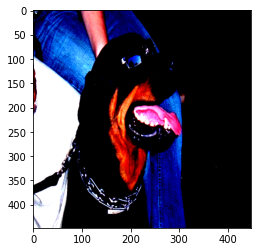

In [31]:
modelInput, modelLabel = next(x)
plot_tensor(modelInput[0], np.array([[0,0,1,1]]))